## Imports

In [1]:
import torch
from torch import nn

from st_nca.common import resume, get_device, checkpoint_all
from st_nca.datasets.PEMS import PEMS03, PEMS04, PEMS08, get_config as pems_get_config
from st_nca.cellmodel import CellModel, load_config, get_config, save_as, setup
from st_nca.pretrain import training_loop
from st_nca.gca import GraphCellularAutomata, timestamp_generator
from st_nca.finetune import FineTunningDataset, finetune_loop
from st_nca.evaluate import evaluate, diff_states

## General Codes

In [3]:
DATASET = 8
DEVICE = get_device()
DTYPE = torch.float32
DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'
#DEFAULT_PATH = 'D:\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'
DATA_PATH = DEFAULT_PATH + 'data\\PEMS0{}\\'.format(DATASET)
MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS0{}\\'.format(DATASET)


## 1 Step Ahead (5 Minutes / 12 NGCA iterations)

In [ ]:
CM_FILE = MODELS_PATH + 'cm3x16x1024_3x1024_h1_smape20.pt'

STEPS_AHEAD = 1


pems = PEMS08(edges_file = DATA_PATH + 'edges.csv', data_file = DATA_PATH + 'data.csv',
    device = DEVICE, dtype = DTYPE, steps_ahead = STEPS_AHEAD)

In [ ]:
config = {
    'num_tokens': pems.max_length,
    'dim_token': pems.token_dim,
    'num_transformers': 3,
    'num_heads': 16,
    'transformer_feed_forward': 1024,
    'transformer_activation': nn.GELU(approximate='none'),
    'normalization': torch.nn.modules.normalization.LayerNorm,
    'pre_norm': False,
    'feed_forward': 3,
    'feed_forward_dim': 1024,
    'feed_forward_activation': nn.GELU(approximate='none'),
    'device': DEVICE,
    'dtype': DTYPE,
    'steps_ahead': STEPS_AHEAD
 }

FLAUTIM_FILE = MODELS_PATH + 'OlwLedGbWh2XBP3yn_8iG_weights.h5'


save_as(FLAUTIM_FILE, CM_FILE, pems, config = config)

In [ ]:
model, pems = setup(CM_FILE, pems, get_device())

### Setup NGCA and Finetune

In [ ]:
gca = GraphCellularAutomata(device=model.device, dtype=model.dtype, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)


In [ ]:
finetune_ds = FineTunningDataset(pems, increment_type='hours', increment=1, steps_ahead=1, step=250)

finetune_loop(get_device(), finetune_ds, gca, 
              #iterations = 1, increment_type='minutes', increment=5,
              iterations = 1, increment_type='hours', increment=1,
              epochs = 150, batch = 1, lr = 0.00001,
              checkpoint_file =  MODELS_PATH + 'gca3x16x1024_h12.pt')

### Evaluation

In [ ]:
df = evaluate(finetune_ds.test(), gca, 1, increment_type='hour', increment=1)
df.describe()

## 12 Steps Ahead (1 hour / 1 NGCA iteration)

In [4]:
CM_FILE = MODELS_PATH + 'cm3x16x1024_3x1024_h12_smape20.pt'

STEPS_AHEAD = 12


pems = PEMS08(edges_file = DATA_PATH + 'edges.csv', data_file = DATA_PATH + 'data.csv',
    device = DEVICE, dtype = DTYPE, steps_ahead = STEPS_AHEAD)

### Import Cell Model

In [5]:
config = {
    'num_tokens': pems.max_length,
    'dim_token': pems.token_dim,
    'num_transformers': 3,
    'num_heads': 16,
    'transformer_feed_forward': 1024,
    'transformer_activation': nn.GELU(approximate='none'),
    'normalization': torch.nn.modules.normalization.LayerNorm,
    'pre_norm': False,
    'feed_forward': 3,
    'feed_forward_dim': 1024,
    'feed_forward_activation': nn.GELU(approximate='none'),
    'device': DEVICE,
    'dtype': DTYPE,
    'steps_ahead': STEPS_AHEAD
 }

FLAUTIM_FILE = MODELS_PATH + 'OlwLedGbWh2XBP3yn_8iG_weights.h5'


save_as(FLAUTIM_FILE, CM_FILE, pems, config = config)

In [10]:
model, pems = setup(CM_FILE, pems, get_device())

c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\cellmodel.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_config = torch.load(file)


{'num_heads': 16, 'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'transformer_feed_forward': 1024, 'transformer_activation': GELU(approximate='none'), 'num_tokens': 10, 'dim_token': 7, 'num_transformers': 3, 'feed_forward': 3, 'feed_forward_dim': 1024, 'feed_forward_activation': GELU(approximate='none'), 'device': 'cuda', 'dtype': torch.float32, 'steps_ahead': 12, 'config': {'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'steps_ahead': 12}}


### Setup NGCA and Finetune

In [11]:
gca = GraphCellularAutomata(device=model.device, dtype=model.dtype, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)


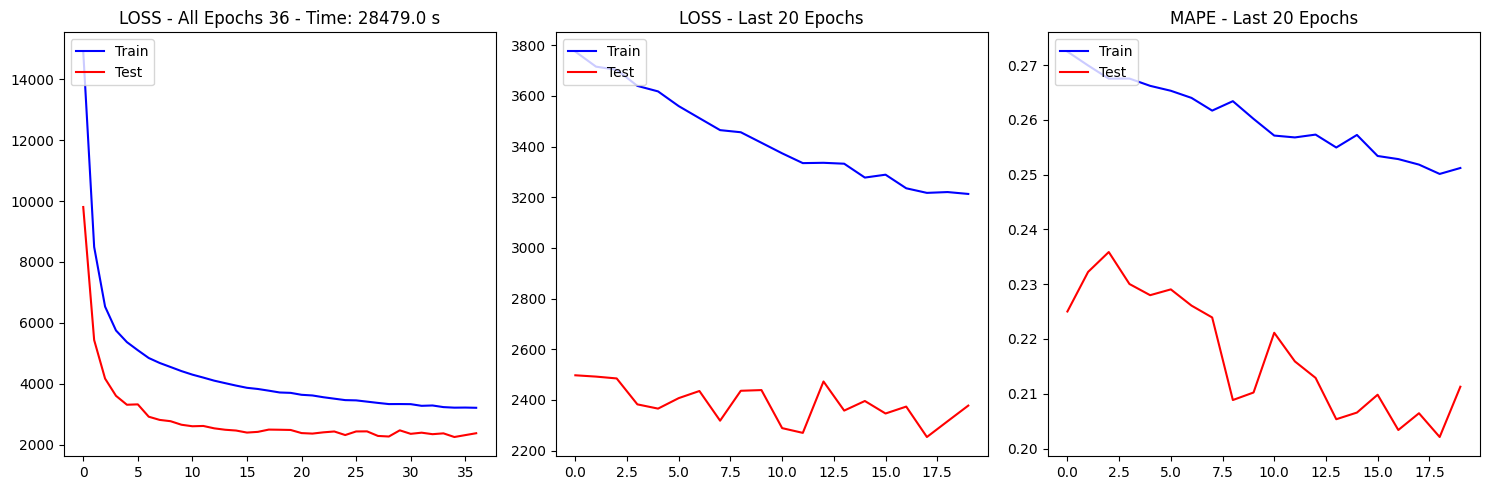

ERROR!: Initial date: 2016-07-07 02:25:00   Error date: 2016-07-07 03:25:00


In [ ]:
finetune_ds = FineTunningDataset(pems, increment_type='hours', increment=1, steps_ahead=1, step=6)

finetune_loop(get_device(), finetune_ds, gca, 
              #iterations = 1, increment_type='minutes', increment=5,
              iterations = 1, increment_type='hours', increment=1,
              epochs = 150, batch = 1, lr = 0.00001,
              checkpoint_file =  MODELS_PATH + 'gca3x16x1024_h12_3.pt')

### Evaluation

In [1]:
df = evaluate(finetune_ds.test(), gca, 1, increment_type='hour', increment=1)
df.describe()

NameError: name 'evaluate' is not defined